In [1]:
import collections

import numpy
import pandas
import plotnine
import scipy.stats

from hetmech.hetmat import HetMat

%matplotlib inline

In [2]:
hetmat = HetMat('../data/hetionet-v1.0.hetmat/')

In [3]:
select_metapaths = ['DaGiG', 'DaGbC', 'DtC', 'DuGcG', 'DdGcG', 'DdGeA']

dwpc_path = hetmat.directory.joinpath('adjusted-path-counts', 'dwpc-0.5', 'adjusted-dwpcs')

values_dict = {}
for metapath in select_metapaths:
    df = pandas.read_table(dwpc_path.joinpath(f'{metapath}.tsv'))
    values_dict[metapath] = df.replace([numpy.inf, -numpy.inf], numpy.nan).dropna()['z-dwpc'].values

In [4]:
def ks_norm_test(data, sided='less'):
    """
    Perform a Kolmogorov-Smirnov test to compare the distribution of Z-DWPC values with
    the standard normal distribution. KS statistic returned is equal to the the area
    of the data PDF above the standard normal PDF that lies outside the intersection of
    the two curves. For more information, see 
    https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test
    """
    data = numpy.sort(numpy.asarray(data))
    df = pandas.DataFrame.from_dict({'data': data})
    cdf = numpy.arange(0, len(data)) / len(data)
    norm_cdf = scipy.stats.norm.cdf(data)
    diff = norm_cdf - cdf

    info = collections.OrderedDict({'z': data, 'data-cdf': cdf, 'norm-cdf': norm_cdf, 'ks': diff})
    df = pandas.DataFrame.from_dict(info)
    
    if sided == 'two':
        df['ks'] = abs(df['ks'])
    elif sided == 'greater':
        df['ks'] = -df['ks']
        
    # Find the CDF difference beyond the last intersection, where Z-values are all positive.
    ksstat = df.iloc[df[df['z'] > 0]['ks'].idxmax(axis=1)].to_dict()
    
    # Calculate p-value using the limiting value Kolmogorov-Smirnov distribution See: https://git.io/vhVpc
    p = scipy.special.kolmogorov(ksstat['ks'] * numpy.sqrt(len(data)))
    ksstat['p-value'] = p
    
    return ksstat

In [5]:
results = ks_norm_test(values_dict['DaGiG'])
results

{'z': 2.5189968128971856,
 'data-cdf': 0.9744070619127949,
 'norm-cdf': 0.9941155139010647,
 'ks': 0.01970845198826976,
 'p-value': 0.0}

In [6]:
x = numpy.linspace(-10,10,1000)
y = scipy.stats.norm.pdf(x)
st_norm = pandas.DataFrame([x, y]).T.rename(columns={0: 'x', 1: 'y'})

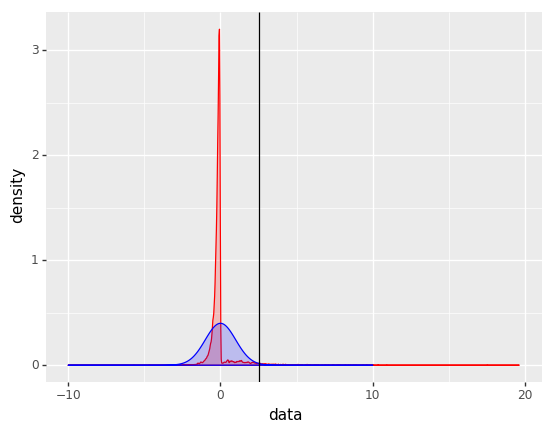

<ggplot: (-9223363304117831778)>

In [7]:
data = pandas.DataFrame.from_dict({'data': values_dict['DaGiG']})
data = data.sample(n=10000)

(plotnine.ggplot() 
 + plotnine.geoms.geom_density(plotnine.aes('data'), data=data, alpha=0.2, color='r', fill='r')
 + plotnine.geom_area(plotnine.aes(x='x', y='y'), data=st_norm, alpha=0.2, color='b', fill='b')
 + plotnine.geoms.geom_vline(xintercept=results['z'])
)

This method should be compared with the built-in scipy method. Unlike that method, we return the Z-value of where PDFs intersect, or the coordinate where the KS statistic is found. Moreover, unlike that method, we are only interested in the KS statistic at Z-values above zero, in order to measure the extra tail of true significance beyond what would be expected under the null hypothesis. If we did not filter for positive Z-values, then our result would be identical to the below function.

In [8]:
scipy.stats.kstest(values_dict['DaGiG'], 'norm', alternative='less')

KstestResult(statistic=0.20885682904866085, pvalue=0.0)

### Explanation

The KS statistic above is equal to the difference in areas to the right of the green line above. Since the orange distribution has a greater variance, it has a higher area beyond the intersection. The alternate hypothesis that the orange is 'less' than the blue means that the CDF of the orange distribution is below the CDF of the blue curve. In this case, this hypothesis is correct. Orange CDF < Blue CDF and Orange PDF > Blue PDF.

In [9]:
draws = numpy.random.normal(0, numpy.sqrt(5), 100000)
st_norm = numpy.random.normal(0, 1, 100000)

data = pandas.DataFrame.from_dict({'draws': draws, 'st-norm': st_norm})

In [10]:
scipy.stats.kstest(draws, 'norm', alternative='less')

KstestResult(statistic=0.18345969505153614, pvalue=0.0)

In [11]:
results = ks_norm_test(data['draws'])
results

{'z': 1.3853004706417544,
 'data-cdf': 0.73356,
 'norm-cdf': 0.9170196950515361,
 'ks': 0.18345969505153614,
 'p-value': 0.0}

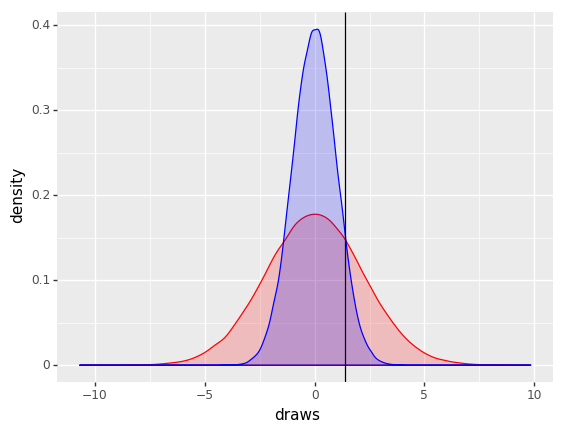

<ggplot: (-9223363304123345769)>

In [12]:
(plotnine.ggplot() 
 + plotnine.geoms.geom_density(plotnine.aes('draws'), data=data, alpha=0.2, color='r', fill='r')
 + plotnine.geoms.geom_density(plotnine.aes('st-norm'), data=data, alpha=0.2, color='b', fill='b')
 + plotnine.geoms.geom_vline(xintercept=results['z'])
)